<a href="https://colab.research.google.com/github/marcusbenard/ml-brain-tumor-detection/blob/main/Brain_tumor_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy>=1.26.4
!pip install pandas>=2.2.2
!pip install matplotlib>=3.9.0
!pip install opencv-python-headless>=4.10.0.82
!pip install torch>=2.3.1
!pip install torchvision>=0.18.1

In [ ]:
#Importing the required libraries
import numpy as np
import cv2 as cv
import zipfile
import io
import requests
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import warnings

from torch.utils.data import DataLoader
from torchvision.utils import make_grid

from PIL import Image

# Use this section to suppress the warnings generated by the codes

def warn(*args, **kwargs):
  pass

warnings.warn = warn
warnings.filterwarnings('ignore')



In [ ]:
# Define the link to the ZIP file
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/o_kRuP_Bk_Pa2xvo1ly63w/data.zip'


def normalize(image):
    """
        Normalize the image to be in range 0 to 1

        Args:
            image: The input image
        Returns:
            The normalized image
    """
    return np.array(image) / 255.0


def center_crop(img, output_size):
    """
        Crop the image from the center

        Args:
            img: The input image
            output_size: The size of the output image
        Returns:
            The cropped image
    """
    img = np.array(img)

    start_y = (img.shape[0] - output_size[0]) // 2
    start_x = (img.shape[1] - output_size[1]) // 2

    cropped_img = img[start_y:start_y + output_size[0], start_x:start_x + output_size[1]]
    return cropped_img


def shape_process(img, input_size):
    """
    Resize the image if its height is odd and pad it to match the input size.

    Args:
        img (numpy array): The input image.
        input_size (tuple): The desired size of the output image as a tuple (height, width).

    Returns:
        numpy array: The processed image with the specified input size.
    """
    if img.shape[0] % 2:
        img = cv.resize(img, img.shape[0] // 2, interpolation=cv.INTER_CUBIC)
    padd = int((input_size[0] - img.shape[0]) / 2)
    img = cv.copyMakeBorder(img, padd, padd, padd, padd, cv.BORDER_REFLECT_101)

    return img



# Download the ZIP file
response = requests.get(zip_file_url)
zip_file_bytes = io.BytesIO(response.content)

# Initialize lists to hold images and labels
test_images = []
train_labels = []
train_images = []

with zipfile.ZipFile(zip_file_bytes, 'r') as zip_ref:
    sorted_files = sorted(zip_ref.namelist())
    for file_name in sorted_files:
        if file_name.endswith('.tif'):
            with zip_ref.open(file_name) as file:
                img = Image.open(file).convert('L')  # Convert to grayscale
                img = np.array(img)
                if '/train/images/' in file_name:
                    train_images.append(normalize(shape_process(img, (572, 572))))
                elif '/train/labels/' in file_name:
                    cropped_img = center_crop(img, (388, 388))
                    normalized_img = normalize(cropped_img)
                    mask = (normalized_img > 0.5).astype(int)
                    train_labels.append(mask)
                elif '/test/' in file_name:
                    test_images.append(normalize(shape_process(img, (572, 572))))

    train_images = np.asarray(train_images, dtype=np.float32)
    # [N, H, W, C]
    train_images = train_images[:, :, :, np.newaxis]

    test_images = np.asarray(test_images, dtype=np.float32)
    test_images = test_images[:, :, :, np.newaxis]

    train_labels = np.asarray(train_labels, dtype=np.float32)
    train_labels = train_labels[:, :, :, np.newaxis]

In [ ]:
print(f'train_images.shape: {train_images.shape}')
print(f'train_labels.shape: {train_labels.shape}')
print(f'test_images.shape: {test_images.shape}')

train_images.shape: (30, 572, 572, 1)
train_labels.shape: (30, 388, 388, 1)
test_images.shape: (30, 572, 572, 1)


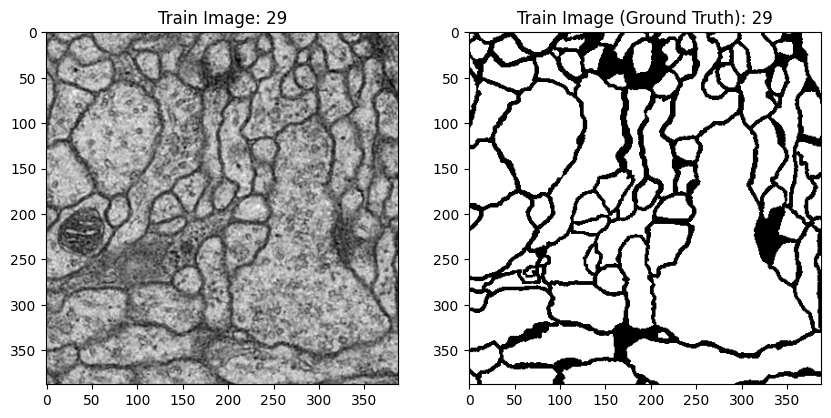

In [ ]:
# Please try different index here, e.g. 1, 2, 3, ..., 29.
sample_image_index = 29

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

In [ ]:
from torch import nn


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Downsampling path
        self.conv1 = self.double_conv(1, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = self.double_conv(64, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = self.double_conv(128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv4 = self.double_conv(256, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5 = self.double_conv(512, 1024)

        # Upsampling path
        self.upconv4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        # concat conv4 + up_conv1
        self.conv6 = self.double_conv(512 + 512, 512)

        self.up_conv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        # concat conv3 + up_conv2
        self.conv7 = self.double_conv(256 + 256, 256)

        self.up_conv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # concat conv2 + up_conv3
        self.conv8 = self.double_conv(128 + 128, 128)

        self.up_conv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        # concat conv1 + up_conv4
        self.conv9 = self.double_conv(64 + 64, 64)

        self.conv10 = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1)

    def double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=0),
            nn.ReLU(inplace=True)
        )

    def center_crop(self, source_tensor, target_shape):
        start_y = (source_tensor.shape[2] - target_shape[2]) // 2
        start_x = (source_tensor.shape[3] - target_shape[3]) // 2

        return source_tensor[:, :, start_y:start_y + target_shape[2], start_x:start_x + target_shape[3]]

    def forward(self, x):
        # Downsampling path
        c1 = self.conv1(x)
        p1 = self.pool1(c1)

        c2 = self.conv2(p1)
        p2 = self.pool2(c2)

        c3 = self.conv3(p2)
        p3 = self.pool3(c3)

        c4 = self.conv4(p3)
        p4 = self.pool4(c4)

        x = self.conv5(p4)

        x = self.up_conv1(x)
        x = torch.cat((self.center_crop(c4, x.shape), x), dim=1)
        x = self.conv6(x)

        x = self.up_conv2(x)
        x = torch.cat((self.center_crop(c3, x.shape), x), dim=1)
        x = self.conv7(x)

        x = self.up_conv3(x)
        x = torch.cat((self.center_crop(c2, x.shape), x), dim=1)
        x = self.conv8(x)

        x = self.up_conv4(x)
        x = torch.cat((self.center_crop(c1, x.shape), x), dim=1)
        x = self.conv9(x)

        output = torch.sigmoid(self.conv10(x))

        return output


In [ ]:
model = UNet()
print(model)

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

In [ ]:
# Device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
input_tensor = torch.randn(1, 1, 572, 572)


def print_size(module, input, output):
    print(f"{module.__class__.__name__} output size: {output.size()}")


for layer in model.children():
    layer.register_forward_hook(print_size)


with torch.no_grad():
    output = model(input_tensor)

print("Final output size:", output.size())

Sequential output size: torch.Size([1, 64, 568, 568])
MaxPool2d output size: torch.Size([1, 64, 284, 284])
Sequential output size: torch.Size([1, 128, 280, 280])
MaxPool2d output size: torch.Size([1, 128, 140, 140])
Sequential output size: torch.Size([1, 256, 136, 136])
MaxPool2d output size: torch.Size([1, 256, 68, 68])
Sequential output size: torch.Size([1, 512, 64, 64])
MaxPool2d output size: torch.Size([1, 512, 32, 32])
Sequential output size: torch.Size([1, 1024, 28, 28])
ConvTranspose2d output size: torch.Size([1, 512, 56, 56])
Sequential output size: torch.Size([1, 512, 52, 52])
ConvTranspose2d output size: torch.Size([1, 256, 104, 104])
Sequential output size: torch.Size([1, 256, 100, 100])
ConvTranspose2d output size: torch.Size([1, 128, 200, 200])
Sequential output size: torch.Size([1, 128, 196, 196])
ConvTranspose2d output size: torch.Size([1, 64, 392, 392])
Sequential output size: torch.Size([1, 64, 388, 388])
Conv2d output size: torch.Size([1, 1, 388, 388])
Final output si

In [ ]:
from torch.utils.data import DataLoader, TensorDataset, random_split

# Create data loaders
batch_size = 1

# Create tensors for the first 6 images (3 for training, 3 for validation)
train_tensor = torch.from_numpy(train_images[:6]).permute(0, 3, 1, 2).float().to(device)
train_groundtruth_tensor = torch.from_numpy(train_labels[:6]).permute(0, 3, 1, 2).float().to(device)

dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

# Set seed for reproducibility
torch.manual_seed(42)

# Define the split sizes
train_size = int(0.8 * len(dataset))  # 80% for training
val_size = len(dataset) - train_size  # 20% for validation

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
# train_dataset = TensorDataset(train_tensor, train_groundtruth_tensor)

train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
from tqdm.notebook import tqdm

model = UNet().to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 7

train_losses = []
val_losses = []

# Training and validation loop
for e in tqdm(range(epochs), leave=False, desc="Epoch"):
    model.train()
    epoch_train_loss = 0  # To accumulate loss for each epoch

    for data, labels in tqdm(train_dl, leave=False, desc="   Training Dataset"):
        optim.zero_grad()
        prediction = model(data)
        loss = F.mse_loss(prediction, labels)
        loss.backward()
        optim.step()
        epoch_train_loss += loss.item()  # Summing up the loss for the epoch

    average_train_loss = epoch_train_loss / len(train_dl)
    train_losses.append(average_train_loss)

    # Validation step
    model.eval()
    epoch_val_loss = 0  # To accumulate loss for validation
    with torch.no_grad():
        for data, labels in tqdm(val_dl, leave=False, desc="   Validation Dataset"):
            prediction = model(data)
            loss = F.mse_loss(prediction, labels)
            epoch_val_loss += loss.item()  # Summing up the loss for the epoch

    average_val_loss = epoch_val_loss / len(val_dl)
    val_losses.append(average_val_loss)

    print(f"Epoch {e+1}, Train Loss: {average_train_loss:.4f}, Val Loss: {average_val_loss:.4f}")



Epoch:   0%|          | 0/7 [00:00<?, ?it/s]

   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 1, Train Loss: 0.2264, Val Loss: 0.2197


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 2, Train Loss: 0.1941, Val Loss: 0.1601


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 3, Train Loss: 0.1680, Val Loss: 0.1510


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 4, Train Loss: 0.1594, Val Loss: 0.1395


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 5, Train Loss: 0.1417, Val Loss: 0.1186


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 6, Train Loss: 0.1314, Val Loss: 0.1116


   Training Dataset:   0%|          | 0/4 [00:00<?, ?it/s]

   Validation Dataset:   0%|          | 0/2 [00:00<?, ?it/s]

Epoch 7, Train Loss: 0.1196, Val Loss: 0.1024


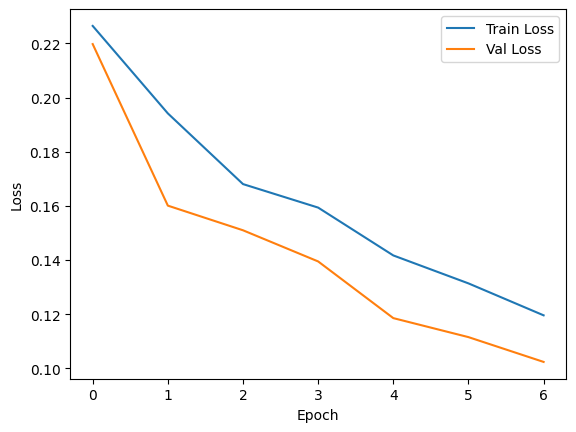

In [ ]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
def download_pt_file(url):
    response = requests.get(url)
    return io.BytesIO(response.content)


pt_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/Iu482aowoEaP9MgNqhyJ_w/model-epo300.pt'
state_dict = torch.load(download_pt_file(pt_file_url), map_location=torch.device(device))

model = UNet().to(device)
model.load_state_dict(state_dict)
model.eval()

UNet(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d

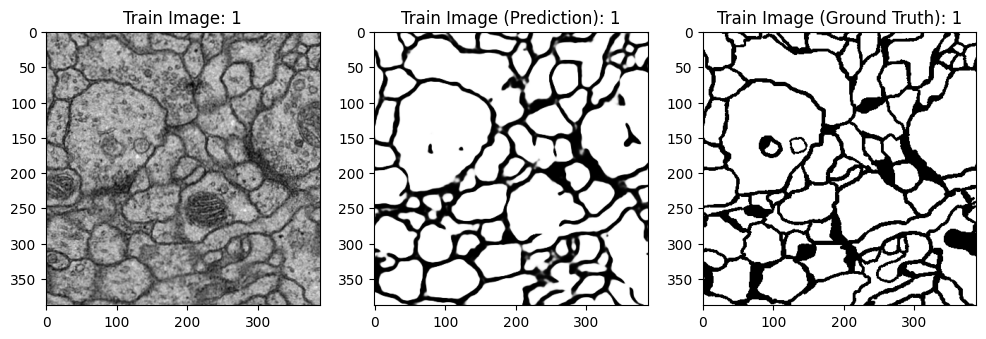

In [ ]:
# Try different sample_image_index here.
sample_image_index = 1

predictions = []
test_tensor = torch.from_numpy(train_images[sample_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(np.squeeze(center_crop(train_images[sample_image_index], (388, 388))), cmap='gray')
plt.title(f'Train Image: {sample_image_index}')
plt.subplot(1, 3, 2)
plt.imshow(make_grid(prediction.cpu())[0].numpy(), cmap='gray')
plt.title(f'Train Image (Prediction): {sample_image_index}')
plt.subplot(1, 3, 3)
plt.imshow(np.squeeze(train_labels[sample_image_index]), cmap='gray')
plt.title(f'Train Image (Ground Truth): {sample_image_index}')
plt.show()

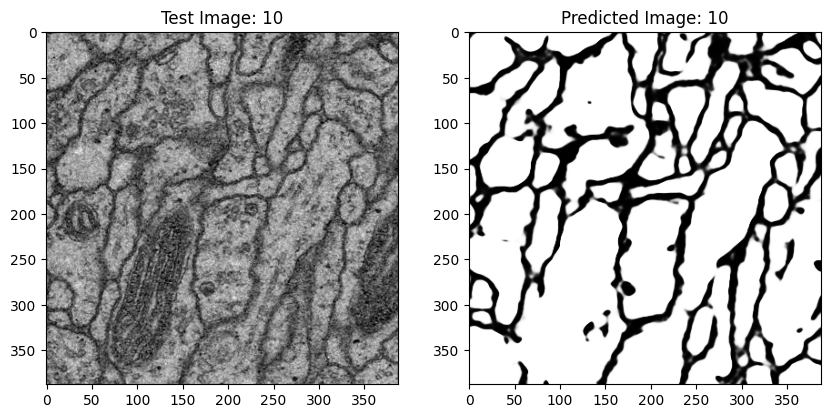

In [ ]:
# Change the image_index here.
test_image_index = 10 # Change this to any number between 0 and 29

predictions = []
test_tensor = torch.from_numpy(test_images[test_image_index]).unsqueeze(0).permute(0, 3, 1, 2).float().to(device)

with torch.no_grad():
    prediction = model(test_tensor)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(center_crop(test_images[test_image_index], (388, 388))), cmap='gray')
plt.title(f'Test Image: {test_image_index}')
plt.subplot(1, 2, 2)
plt.imshow(make_grid(prediction.cpu())[0].numpy(), cmap='gray')
plt.title(f'Predicted Image: {test_image_index}')
plt.show()

Extracted files: ['dataset']


Text(0.5, 1.0, 'Mask')

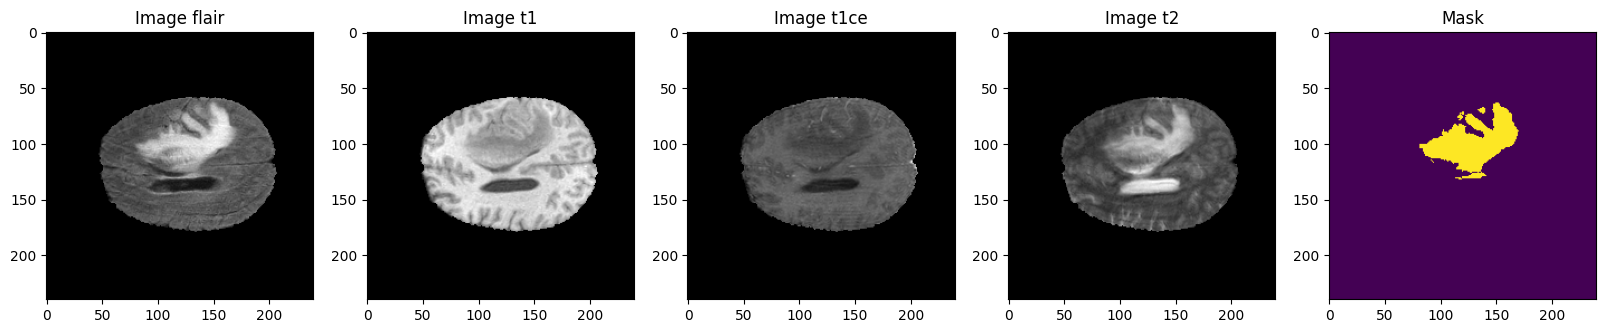

In [ ]:
import os
import cv2
import glob
import PIL
import shutil
import numpy as np
import pandas as pd
# import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
# from skimage.util import montage
# import skimage.transform as skTrans
# from skimage.transform import rotate
# from skimage.transform import resize
# from PIL import Image, ImageOps
import nibabel as nib

import requests
import zipfile
import io
import os

extract_dir = "extracted_files"
if not os.path.exists(extract_dir):
    url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/EFOEudjvmSIMYp700qwtrg/dataset.zip'

    response = requests.get(url)
    zip_file = io.BytesIO(response.content)

    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        # Extract all contents to a specific directory
        zip_ref.extractall("extracted_files")

extracted_files = os.listdir("extracted_files")
print("Extracted files:", extracted_files)

TRAIN_DATASET_PATH = 'extracted_files/dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'
VALIDATION_DATASET_PATH = 'extracted_files/dataset/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData'

test_image_flair=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_flair.nii').get_fdata()
test_image_t1=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1.nii').get_fdata()
test_image_t1ce=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t1ce.nii').get_fdata()
test_image_t2=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_t2.nii').get_fdata()
test_mask=nib.load(TRAIN_DATASET_PATH + 'BraTS20_Training_001/BraTS20_Training_001_seg.nii').get_fdata()


fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_flair[:,:,test_image_flair.shape[0]//2-slice_w], cmap = 'gray')
ax1.set_title('Image flair')
ax2.imshow(test_image_t1[:,:,test_image_t1.shape[0]//2-slice_w], cmap = 'gray')
ax2.set_title('Image t1')
ax3.imshow(test_image_t1ce[:,:,test_image_t1ce.shape[0]//2-slice_w], cmap = 'gray')
ax3.set_title('Image t1ce')
ax4.imshow(test_image_t2[:,:,test_image_t2.shape[0]//2-slice_w], cmap = 'gray')
ax4.set_title('Image t2')
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title('Mask')

In [ ]:
import torch
import torch.nn as nn

def double_convolution(in_channels, out_channels):
    """
    In the original paper implementation, the convolution operations were
    not padded but we are padding them here. This is because, we need the
    output result size to be same as input size.
    """
    conv_op = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    )
    return conv_op

class UNet(nn.Module):
    def __init__(self, num_classes):
        super(UNet, self).__init__()
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)
        # Contracting path.
        # Each convolution is applied twice.
        self.down_convolution_1 = double_convolution(1, 64)
        self.down_convolution_2 = double_convolution(64, 128)
        self.down_convolution_3 = double_convolution(128, 256)
        self.down_convolution_4 = double_convolution(256, 512)
        self.down_convolution_5 = double_convolution(512, 1024)

        # Expanding path
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, out_channels=512,
            kernel_size=2,
            stride=2)

        self.up_convolution_1 = double_convolution(1024, 512)
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, out_channels=256,
            kernel_size=2,
            stride=2)
        self.up_convolution_2 = double_convolution(512, 256)
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, out_channels=128,
            kernel_size=2,
            stride=2)
        self.up_convolution_3 = double_convolution(256, 128)
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, out_channels=64,
            kernel_size=2,
            stride=2)
        self.up_convolution_4 = double_convolution(128, 64)
        # output => `out_channels` as per the number of classes.
        self.out = nn.Conv2d(
            in_channels=64, out_channels=num_classes,
            kernel_size=1
        )

    def forward(self, x):
        down_1 = self.down_convolution_1(x)
        down_2 = self.max_pool2d(down_1)
        down_3 = self.down_convolution_2(down_2)
        down_4 = self.max_pool2d(down_3)
        down_5 = self.down_convolution_3(down_4)
        down_6 = self.max_pool2d(down_5)
        down_7 = self.down_convolution_4(down_6)
        down_8 = self.max_pool2d(down_7)
        down_9 = self.down_convolution_5(down_8)

        up_1 = self.up_transpose_1(down_9)
        up_2 = self.up_convolution_1(torch.cat([down_7, up_1], 1))
        up_3 = self.up_transpose_2(up_2)
        up_4 = self.up_convolution_2(torch.cat([down_5, up_3], 1))
        up_5 = self.up_transpose_3(up_4)
        up_6 = self.up_convolution_3(torch.cat([down_3, up_5], 1))
        up_7 = self.up_transpose_4(up_6)
        up_8 = self.up_convolution_4(torch.cat([down_1, up_7], 1))

        out = self.out(up_8)

        return out

In [ ]:
model = UNet(num_classes=1)

# device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'mps' if torch.backends.mps.is_available() else 'cpu'
print(device)

model.to(device)

from sklearn.model_selection import train_test_split
import os

# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories);

train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.3, random_state=42)
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.3, random_state=42)

print(f"Train: {len(train_ids)} | Validation: {len(val_ids)} | Test: {len(test_ids)}")

cpu
Train: 9 | Validation: 6 | Test: 5


In [ ]:
def load_dataset(ids, path):
    images = np.zeros((len(ids)*10, 240, 240), np.float32)
    masks = np.zeros((len(ids)*10, 240, 240), np.float32)

    i = 0
    for id in ids:
        t2 = nib.load(f"{path}{id}/{id}_t2.nii").get_fdata()
        seg = nib.load(f"{path}{id}/{id}_seg.nii").get_fdata()

        for s in range(50, seg.shape[2]-50, 10):
            images[i] = t2[:, :, s] / t2.max()
            masks[i] = seg[:, :, s] > 0
            i += 1

    images = np.expand_dims(images[:i], axis=1)
    masks = np.expand_dims(masks[:i], axis=1)

    return images, masks

train_images, train_masks = load_dataset(train_ids, TRAIN_DATASET_PATH)
val_images, val_masks = load_dataset(val_ids, TRAIN_DATASET_PATH)

train_images.shape, val_masks.shape

((54, 1, 240, 240), (36, 1, 240, 240))

In [ ]:
def load_dataset(ids, path):
    images = np.zeros((len(ids)*10, 240, 240), np.float32)
    masks = np.zeros((len(ids)*10, 240, 240), np.float32)

    i = 0
    for id in ids:
        t2 = nib.load(f"{path}{id}/{id}_t2.nii").get_fdata()
        seg = nib.load(f"{path}{id}/{id}_seg.nii").get_fdata()

        for s in range(50, seg.shape[2]-50, 10):
            images[i] = t2[:, :, s] / t2.max()
            masks[i] = seg[:, :, s] > 0
            i += 1

    images = np.expand_dims(images[:i], axis=1)
    masks = np.expand_dims(masks[:i], axis=1)

    return images, masks

train_images, train_masks = load_dataset(train_ids, TRAIN_DATASET_PATH)
val_images, val_masks = load_dataset(val_ids, TRAIN_DATASET_PATH)

train_images.shape, val_masks.shape

((54, 1, 240, 240), (36, 1, 240, 240))

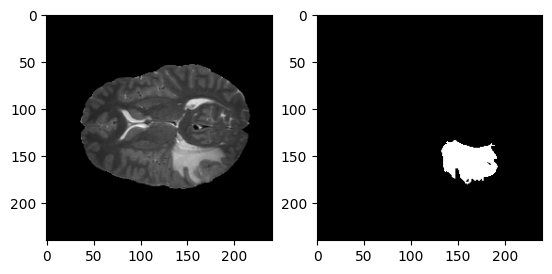

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

batch_size = 8

train_dataset = TensorDataset(torch.from_numpy(train_images).type(torch.float32), torch.from_numpy(train_masks).type(torch.float32))
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(torch.from_numpy(val_images).type(torch.float32), torch.from_numpy(val_masks).type(torch.float32))
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, Y = next(iter(train_dataloader))
plt.subplot(121)
plt.imshow(X[0, 0], cmap='gray')
plt.subplot(122)
plt.imshow(Y[0, 0], cmap='gray')

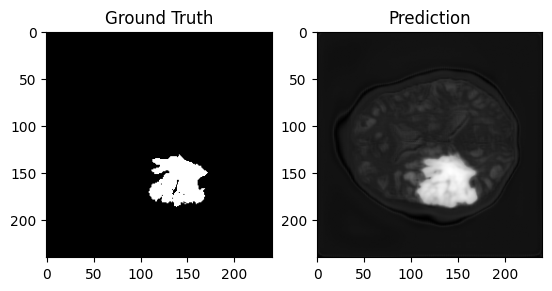

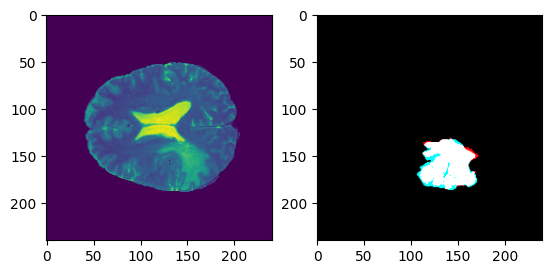

In [ ]:
checkpoint_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/HATpl02lA0ykn9aAU9K6sA/checkpoint-epoch-29.pt'
local_checkpoint_path = 'checkpoint-epoch-29.pt'

if not os.path.exists(local_checkpoint_path):
    response = requests.get(checkpoint_url)
    # Save the downloaded file locally
    with open(local_checkpoint_path, 'wb') as f:
        f.write(response.content)

# Load the checkpoint
checkpoint = torch.load(local_checkpoint_path, map_location=torch.device('cpu'))

# Reinitialize the model architecture
model = UNet(num_classes=1).to(torch.device('cpu'))

# Load the model state dictionary from the checkpoint
model.load_state_dict(checkpoint['model_state_dict'])

# Set the model to evaluation mode
model.eval()

X, y = next(iter(test_dataloader))
X, y = X.to(torch.device('cpu')), y.to(torch.device('cpu'))

with torch.inference_mode():
    y_pred = model(X)

y1 = y[3, 0].cpu().detach().numpy()
y2 = y_pred[3, 0].cpu().detach().numpy()
plt.subplot(121)
plt.imshow(y1, cmap='gray')
plt.title('Ground Truth')
plt.subplot(122)
plt.imshow(y2, cmap='gray')
plt.title('Prediction')
plt.show()


y_color = np.zeros((*y1.shape, 3))
y_color[..., 0] = y1
y_color[..., 1] = y2
y_color[..., 2] = y2


plt.subplot(121)
plt.imshow(X[4, 0].cpu().detach().numpy())
plt.subplot(122)
plt.imshow(y_color)